# Explaining Measures of Fairness with SHAP

This hands-on article connects explainable AI methods with fairness measures and shows how modern explainability methods can enhance the usefulness of quantitative fairness metrics. By using [SHAP](http://github.com/slundberg/shap) (a popular explainable AI tool) we can decompose measures of fairness and allocate responsibility for any observed disparity among each of the model's input features. Explaining these quantitative fairness metrics can reduce the concerning tendency to rely on them as opaque standards of fairness, and instead promote their informed use as tools for understanding how model behavior differs between groups.

[Quantitative fairness metrics] seek to bring mathematical precision to the definition of fairness in machine learning \cite{kearns2019ethical}. Definitions of fairness however are deeply rooted in human ethical principles, and so on value judgements that often depend critically on the context in which a machine learning model is being used. This practical dependence on value judgements manifests itself in the mathematics of quantitative fairness measures as a set of trade-offs between sometimes mutually incompatible definitions of fairness \cite{kleinberg2016inherent}. Since fairness relies on context-dependent value judgements it is dangerous to treat quantitative fairness metrics as opaque black-box measures of fairness \cite{corbett2018measure}, since doing so may obscure important value judgment choices.

<!--To  will not explain

The danger of treating quantitative fairness metrics as opaque, black-box measures of fairness is strikingly similar to a related problem of treating machine learning models themselves as opaque, black-box predictors. While using a black-box is reasonable in many cases, important problems and assumptions can often be hidden (and hence ignored) when users don't understand the reasons behind a model's behavior \cite{ribeiro2016should}. In response to this problem many explainable AI methods have been developed to help users understand the behavior of modern complex models \cite{vstrumbelj2014explaining,ribeiro2016should,lundberg2017unified}. Here we explore how to apply explainable AI methods to quantitative fairness metrics.-->


## A Simulated Case Study

To help us explore the potential usefulness of explaining quantitative fairness metrics we consider a simple simulated scenario based on credit underwriting. In the simulation there are four underlying factors that drive the risk of default for a loan: income stability, income amount, spending restraint, and consistency. These underlying factors are not observed, but they variously influence four different observable features: job history, reported income, credit inquiries, and late payments. Using this simulation we generate random samples and then train a non-linear [XGBoost] classifier to predict the probability of default.

By introducing sex-specific reporting errors into the simulation we can observe how the biases caused by these errors are captured by fairness metrics. For this analysis we use the classic [demographic parity] metric, though the same analysis works with other metrics such as [equalized odds], or [equal opportunity]. Demographic parity states that the output of the machine learning model should be equal between two or more groups. The demographic parity difference is then a measure of how much disparity there is between model outcomes in two groups of samples. Note that which metric is most appropriate for you depends the specifics of your context, such as what laws apply, how the outputs of the machine learning model impact people, and what value you place on various outcomes. We use demographic parity for this scenario not because it is nessecarily the right measure of fairness (it is often not), but simply because it straightforward and commonly known.


<!--This article explores how we can use modern explainable AI tools to enhance traditional quantitative measures of model fairness. It is practical and hands-on, so feel free to follow along in the associated [notebook]. I assume you have a basic understanding of how people measure fairness for machine learning models. If you have never before considered fairness in the context of machine learning, then I recommend starting with a basic introduction such as XXX. I am not writing this Here I do not  beforeIt is not meant to be a definitite  One futher disclaimer is that as the author of SHAP (a popular explainable AI tool) I am very familar with the strengths and weaknesses of explainable AI tools, but I do not consider myself a fairness expert. So consider this a thought-provoking guide on how explainable AI tools can enhance quantitative measures of model fairness

I consider myself fairly well informed about explainable AI, but I 

Questions about fairness and equal treatment naturally arise whenever the outputs of a machine learning model impact people. For sensitive use-cases such as credit underwriting or crime prediction there are even laws that govern certain aspects of fairness. While fairness issues are not new, the rising popularily of machine learning model  

Legal fairness protections are even legally encorced for sensitive use-cases such as credit underwriting or crime prediction, but is also important in many other situations such as quality of service, or you might not initially to consider whenever you are using m Quantifying the fairness of a machine learning model has recently received considerable attention in the research community, and many quantitative fairness metrics have been proposed. In parallel to this work on fairness, explaining the outputs of a machine learning model has also received considerable research attention. %Explainability is intricately connected to fairness, since good explanations enable users to understand a model's behavior and so judge its fairness.

Here we connect explainability methods with fairness measures and show how recent explainability methods can enhance the usefulness of quantitative fairness metrics by decomposing them among the model's input features. Explaining quantitative fairness metrics can reduce our tendency to rely on them as opaque standards of fairness, and instead promote their informed use as tools for understanding model behavior between groups.
  
This notebook explores how SHAP can be used to explain quantitative measures of fairness, and so enhance their usefulness. To do this we consider a simple simulated scenario based on credit underwriting. In the simulation below there are four underlying factors that drive the risk of default for a loan: income stability, income amount, spending restraint, and consistency. These underlying factors are not observed, but they influence four different observable features in various ways: job history, reported income, credit inquiries, and late payments. Using this simulation we generate random samples and then train a non-linear gradient boosting tree classifier to predict the probability of default.

By introducing sex-specific reporting errors into the simulation we can observe how the biases caused by these errors are captured by fairness metrics. For this analysis we use the classic statistical parity metric, though the same analysis works with other metrics. Note that for a more detailed description of fairness metrics you can check out the [fairlearn package's documentation](https://github.com/fairlearn/fairlearn/blob/master/TERMINOLOGY.md#fairness-of-ai-systems).-->

In [1]:
# build data
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import shap
%config InlineBackend.figure_format = 'retina'

def run_credit_experiment(N, job_history_sex_impact=0, reported_income_sex_impact=0,
                          late_payments_sex_impact=0, default_rate_sex_impact=0,
                          include_brandx_purchase_score=False, include_sex=False):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)
    default_rate = income_stability * income_amount * spending_restraint * consistency
    default_rate = np.maximum(default_rate + sex * default_rate_sex_impact, 0)
    
    job_history = np.maximum(10 * income_stability + 2 * np.random.rand(N) - job_history_sex_impact * sex * np.random.rand(N), 0)
    reported_income =  np.maximum(10000 + 90000*income_amount + np.random.randn(N) * 10000 - reported_income_sex_impact * sex * np.random.rand(N), 0)
    credit_inquiries = np.round(6 * np.maximum(spending_restraint - income_amount, 0)) + np.round(np.random.rand(N) > 0.1)
    late_payments = np.maximum(np.round(3 * np.maximum((1-consistency) + 0.2 * (1-income_stability), 0)) + np.round(np.random.rand(N) > 0.1) - np.round(late_payments_sex_impact * sex * np.random.rand(N)), 0)
    
    X = pd.DataFrame({
        "Job history": job_history,
        "Reported income": reported_income,
        "Credit inquiries": credit_inquiries,
        "Late payments": late_payments
    })
    y = default_rate > np.percentile(default_rate, 60)
    
    if include_brandx_purchase_score:
        brandx_purchase_score = sex + 0.8 * np.random.randn(N)
        X["Brand X purchase score"] = brandx_purchase_score
    
    if include_sex:
        X["Sex"] = sex + 0
    
    # build model
    import xgboost
    model = xgboost.XGBClassifier(max_depth=1, n_estimators=500, subsample=0.5, learning_rate=0.05)
    model.fit(X, y)

    # build explanation
    import shap
    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)
    
    return shap_values, sex, X, explainer.expected_value

# this helps us plot the overall group differences
def group_output_plot(outputs, group_mask, group_names=["True", "False"]):
    vs = []
    gmean = group_mask.mean()
    for i in range(1000):
        r = np.random.rand(len(outputs)) > gmean
        vs.append([outputs[r].mean(0), outputs[~r].mean(0)])
    vs = np.array(vs)
    xerr = np.vstack([np.percentile(vs, 95, axis=0), np.percentile(vs, 5, axis=0)])
    pl.figure(figsize=[6.0, 2.5])
    xerr[0] -= outputs[group_mask].mean()
    xerr[1] -= outputs[~group_mask].mean()
    xerr = np.abs(xerr) 
    pl.bar(
        range(2),
        [outputs[group_mask].mean(), outputs[~group_mask].mean()],
        color=shap.plots.colors.blue_rgb, yerr=xerr.T, capsize=3
    )
    ax = pl.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.invert_yaxis()
    ax.set_xticks([0,1])
    ax.set_xticklabels(group_names)
    ax.tick_params(labelsize=12)
    pl.ylabel("Credit worthiness\n(log-odds of default risk)", fontsize=13)
    pl.ylim(0, -1.8)
    pl.show()

N = 10000
xmin = -0.8
xmax = 0.8
gdiff_xlabel = "Demographic parity difference\nof SHAP values"

<!--## Scenario A: No reporting errors

As a baseline experiment we refrain from introducing any sex-specific reporting errors. This results in no significant statistical parity difference between the credit score of men and women:-->

## Scenario A: No reporting errors

Our first experiment is a simple baseline check where we refrain from introducing any sex-specific reporting errors. While we could use any model output to measure demographic parity, we use the continuous log-odds score from a binary XGBoost classifier. As expected, this baseline experiment results in no significant demographic parity difference between the credit scores of men and women. We can see this by plotting the average credit score for women and men as a bar plot and noting that the difference between the bar heights is within the margin of error (note the y-axis is flipped to make taller bars mean lower risk):

 96%|=================== | 9632/10000 [00:11<00:00]       

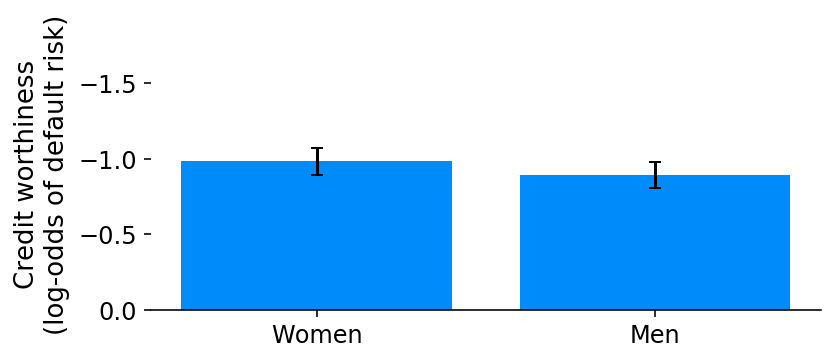

In [2]:
shap_values_A, sex_A, X_A, ev_A = run_credit_experiment(N)
model_outputs_A = ev_A + shap_values_A.sum(1)
group_output_plot(model_outputs_A, ~sex_A, ["Women", "Men"])

The key insight behind why we can use SHAP to explain the demographic parity difference (or other fairness metrics) is that demographic parity relies on comparing the average model output between two groups. Since SHAP decomposes the model output into feature attributions with the same units as the original model output, we can first decompose the model output among each of the input features using SHAP, and then compute the demographic parity difference for each input feature seperately using the SHAP value for that feature. Because the SHAP values sum up to the model's output, the sum of the demographic parity differences of the SHAP values also sum up to the demographic parity difference of the whole model. This means that the sum of the bars below equals the difference between the two bars above (the demographic parity difference of our baseline scenario model).

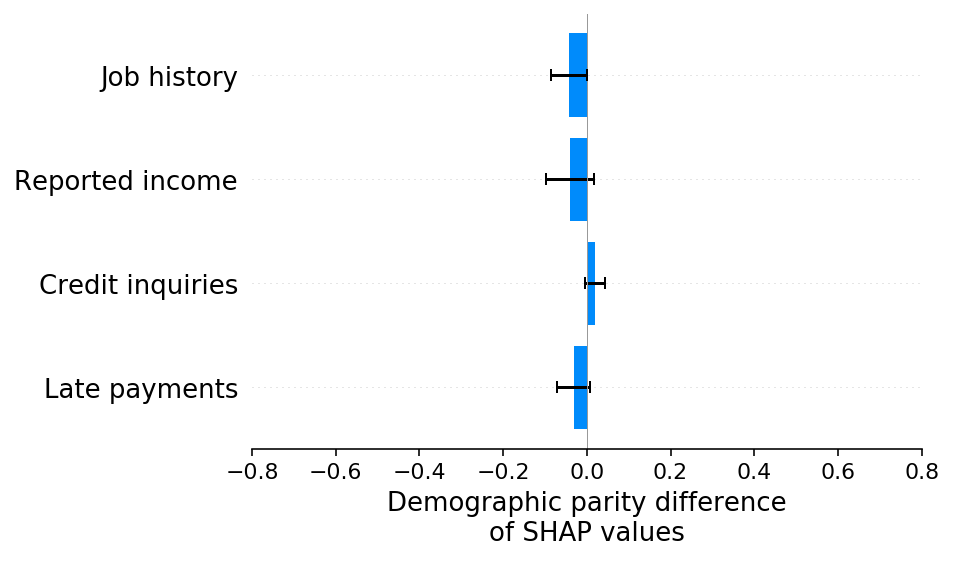

In [3]:
shap.group_difference_plot(shap_values_A, ~sex_A, X_A.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

## Scenario B: An under-reporting bias for women's income

In our baseline scenario we designed a simulation where sex had no impact on any of the features or labels used by the model. Here in scenario B we introduce an under-reporting bias for women's income into the simulation. The point here is not how realistic or not it would be for women's income to be under-reported in the real-world, but rather how we can identify that a sex-specific bias has been introduced and understand where it came from. By plotting the average model output (credit score) for both men and women we can see that the income under-reporting bias has created a significant demographic parity difference:

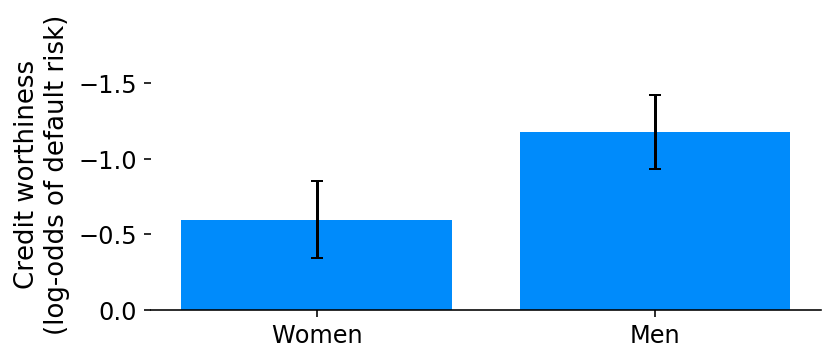

In [4]:
shap_values_B, sex_B, X_B, ev_B = run_credit_experiment(N, reported_income_sex_impact=30000)
model_outputs_B = ev_B + shap_values_B.sum(1)
group_output_plot(model_outputs_B, ~sex_B, ["Women", "Men"])

If this were a real application, this demographic parity difference might trigger an in-depth analysis of the model to determine what might be causing the disparity. While this investigation is challenging given just a single demographic parity difference value, it is much easier given the per-feature statistical parity decomposition based on SHAP, where there is a clearly significant bias coming from the reported income feature that is increasing the risk of women disproportionately to men. Using the SHAP explanation of the demographic parity difference we can quickly identify which feature has the reporting bias that is causing our model to violate demographic parity:

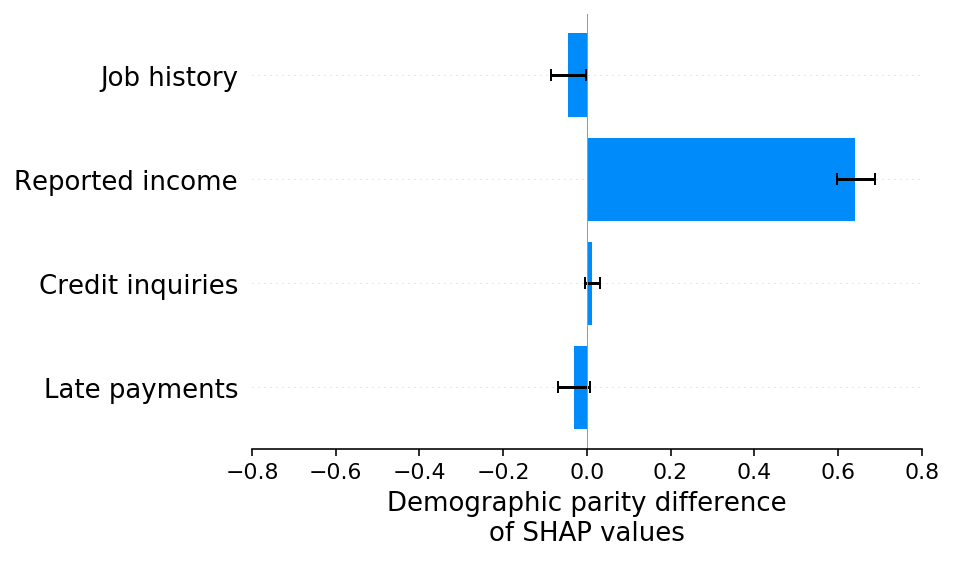

In [5]:
shap.group_difference_plot(shap_values_B, ~sex_B, X_B.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

## Scenario C: An under-reporting bias for women's late payments

To verify that SHAP demographic parity explanations can correctly detect disparies regardless of the direction of effect or source feature, we repeat our previous experiment but instead of an under-reporting for income, we introduce an under-reporting bias for women's late payment rates. This results a moderately significant demographic parity difference for the model's output:

 98%|===================| 9849/10000 [00:11<00:00]       

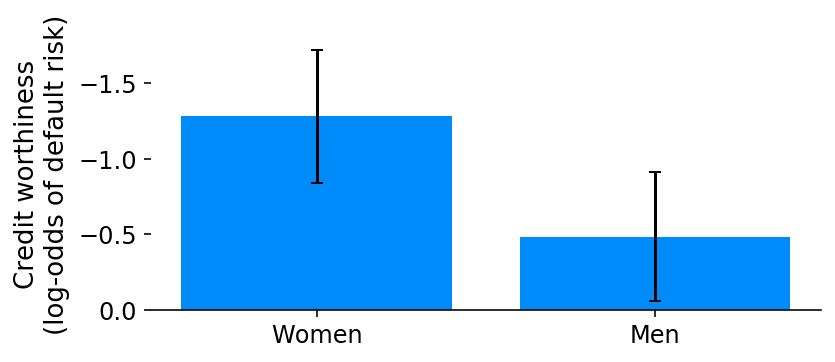

In [6]:
shap_values_C, sex_C, X_C, ev_C = run_credit_experiment(N, late_payments_sex_impact=2)
model_outputs_C = ev_C + shap_values_C.sum(1)
group_output_plot(model_outputs_C, ~sex_C, ["Women", "Men"])

As we would hope, the SHAP explantions correctly highlight the late payments feature as the cause of the model's demographic parity difference, as well as the direction of the effect:

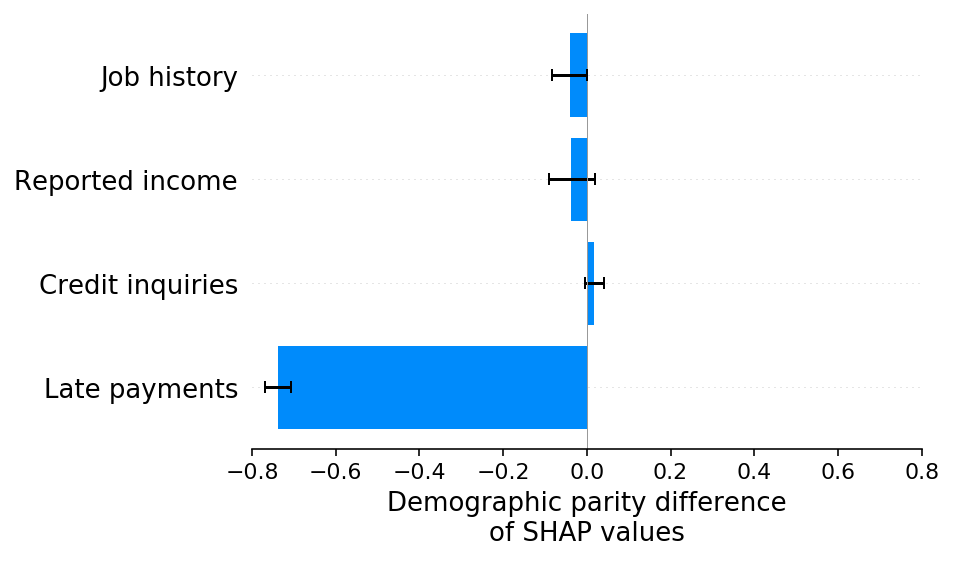

In [7]:
shap.group_difference_plot(shap_values_C, ~sex_C, X_C.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

## Scenario D: An under-reporting bias for women's default rates

The experiments above focused on introducing reporting errors for specific input features. Next we consider what happens when introduce reporting errors on the training labels through an under-reporting bias on women's default rates. Interestingly, for this simulated scenario this results in no significant demographic parity differences in model's output:

 98%|===================| 9826/10000 [00:11<00:00]       

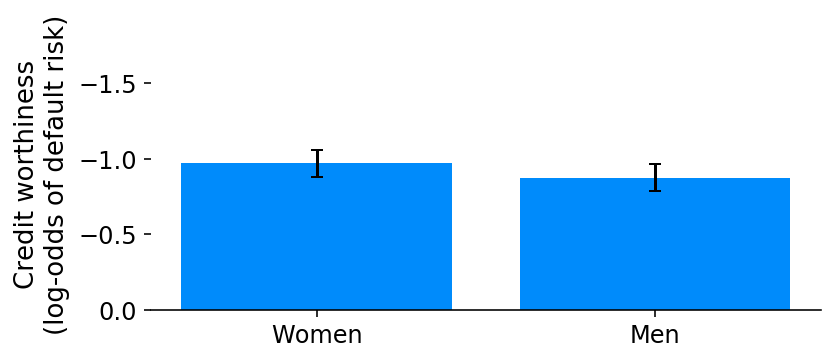

In [8]:
shap_values_D, sex_D, X_D, ev_D = run_credit_experiment(N, default_rate_sex_impact=.02)
model_outputs_D = ev_D + shap_values_D.sum(1)
group_output_plot(model_outputs_D, ~sex_D, ["Women", "Men"])

We also see no evidence of any demographic parity differences in the SHAP explanations.

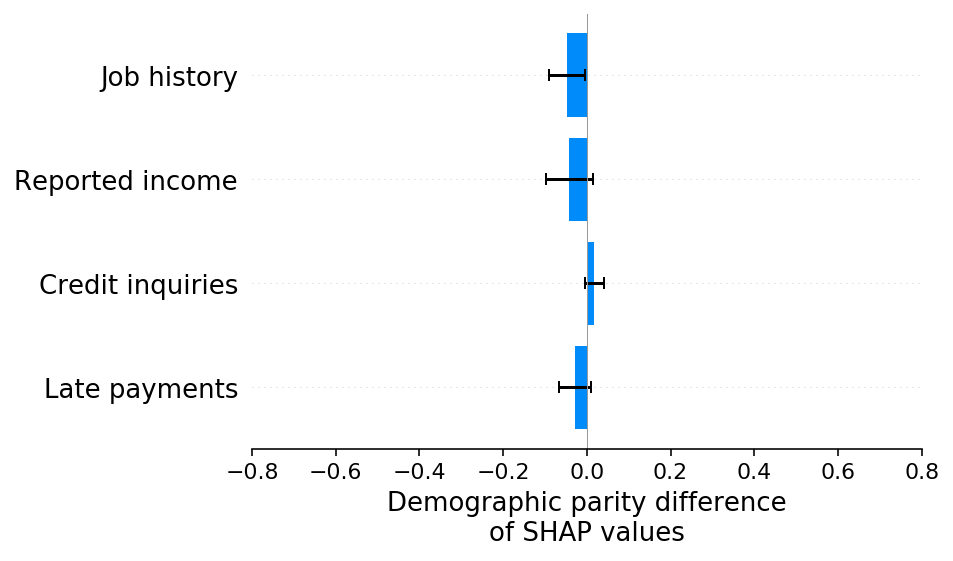

In [9]:
shap.group_difference_plot(shap_values_D, ~sex_D, X_D.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

## Scenario E: An under-reporting bias for women's default rates, take 2

It may at first be surprising that no statistical parity differences were caused when we introduced an under-reporting bias on women's default rates. This is beacause none of the four features in our simulation are significantly correlated with sex, so none of them could be effectively used to model the bias we introduced into the training labels. If we now instead provide a new feature (brand X purchase score) to the model that is correlated with sex, then we see a statistical parity difference emerge as that feature is used by the model to capture the sex-specific bias in the training labels.

 94%|=================== | 9427/10000 [00:11<00:00]       

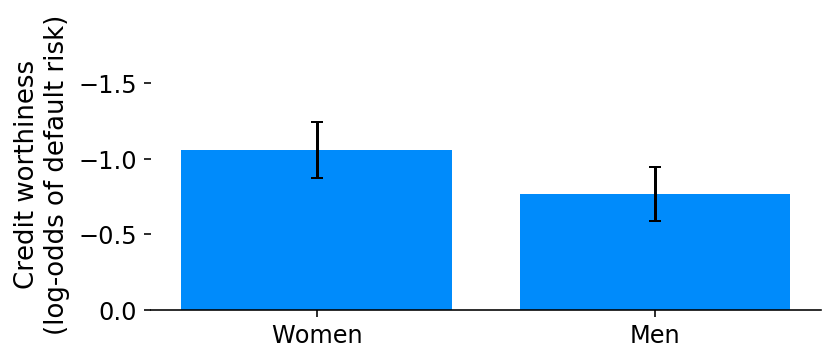

In [10]:
shap_values_E, sex_E, X_E, ev_E = run_credit_experiment(
    N, default_rate_sex_impact=.02, include_brandx_purchase_score=True
)
model_outputs_E = ev_E + shap_values_E.sum(1)
group_output_plot(model_outputs_E, ~sex_E, ["Women", "Men"])

When we explain the statistical parity difference with SHAP we see that, as expected, the brand X purchase score feature drives the difference. In this case it is not because we have a bias in how we measure the brand X purchase score feature, but rather because we have a bias in our training label that gets captured by any input features that are suffciently correlated with sex:

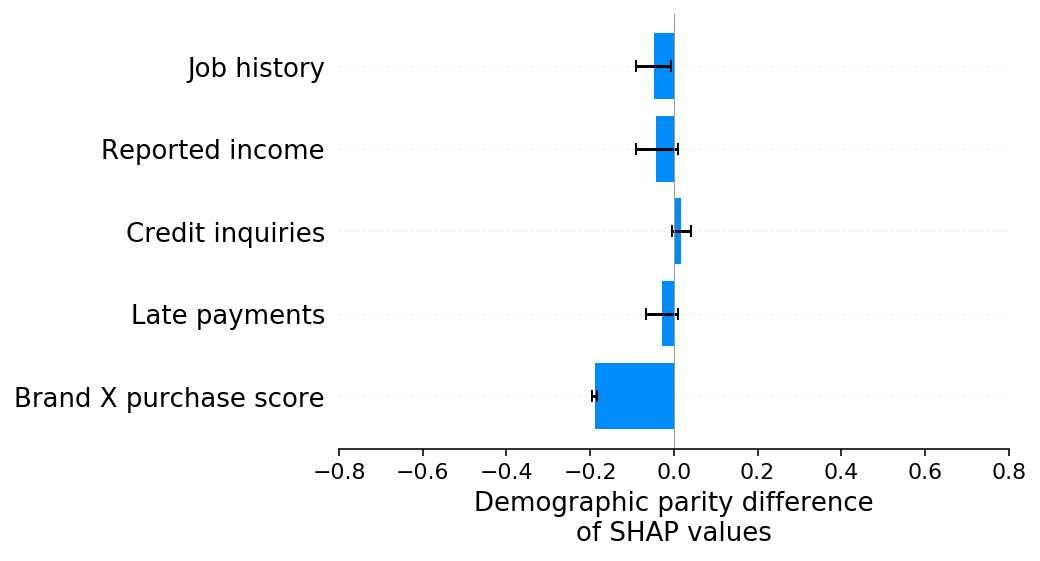

In [11]:
shap.group_difference_plot(shap_values_E, ~sex_E, X_E.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

## Scenario F: Teasing apart multiple under-reporting biases

When there is a single cause of reporting bias then both the classic demographic parity test on the model's output, and the SHAP explanation of the demographic parity test capture the same bias effect (though the SHAP explanation can often have more statistical significance since it isolates the feature causing the bias). But what happens when there are multiple causes of bias occuring in a dataset? In this experiment we introduce two such biases, an under-reporting of women's default rates, and an under-reporting of women's job history. These biases tend to offset eachother in the global average and so the classic statistical parity test on the model's output shows no measureable disparity:

 96%|=================== | 9597/10000 [00:11<00:00]       

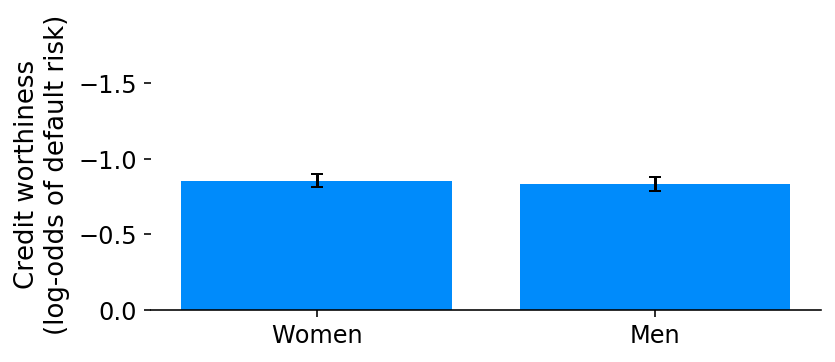

In [12]:
shap_values_F, sex_F, X_F, ev_F = run_credit_experiment(
    N, default_rate_sex_impact=.02, include_brandx_purchase_score=True,
    job_history_sex_impact=2
)
model_outputs_F = ev_F + shap_values_F.sum(1)
group_output_plot(model_outputs_F, ~sex_F, ["Women", "Men"])

However, if we look at the SHAP explaination of the statistical parity difference we clearly see both (counteracting) biases:

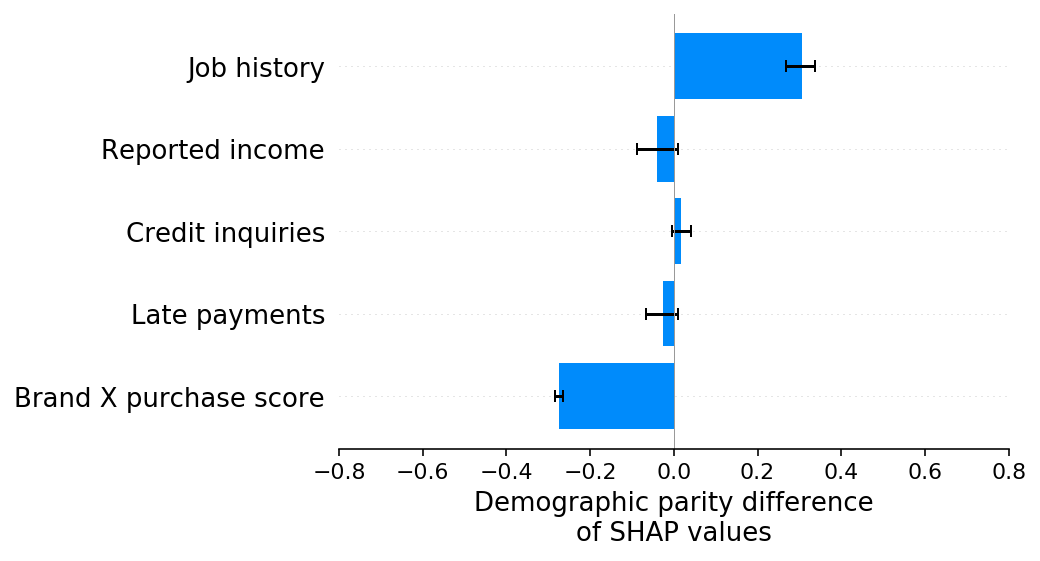

In [13]:
shap.group_difference_plot(shap_values_F, ~sex_F, X_F.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

Identifying multiple potentially offsetting bias effects can be important since while on average there is no disparate impact on men or women, there is disparate impact on individuals. For example, in this simulation women who have not shopped at brand X will recive a lower credit score than they should have because of the bias present in job history reporting.

## Scenario G: Teasing apart label biases vs. feature biases (scratch below here)

In scenario F we were able to pick apart two distict forms of bias, one coming from job history under-reporting and one coming from default rate under-reporting. However, the bias from default rate under-reporting was not attributed to the default rate label, but rather to the brand X purchase score feature that happened to be correlated with sex. This still leaves us with some uncertainty about the true sources of statistical parity differences, since any difference attributed to an input feature could be due to an issue with that feature, or due to an issue with the training labels.

SHAP fairness explanations are not able to address every problem, but it turns out that in this case we can help disentangle label bias from feature bias by introducing sex as a variable directly into the model. The goal of introducing sex as an input feature is to cause the label bias to fall entirely on the sex feature, leaving the feature biases untouched. So we can then distinguish between label biases and feature biases by comparing the results of scenario F above to out new scenario G. This of course creates an even stronger demographic parity difference than we had before, but that is fine since our goal is not bias mitigation, but rather bias understanding.

 94%|=================== | 9360/10000 [00:11<00:00]       

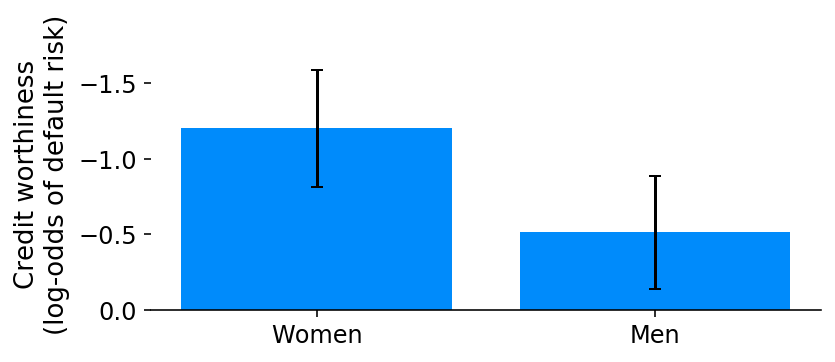

In [14]:
shap_values_G, sex_G, X_G, ev_G = run_credit_experiment(
    N, default_rate_sex_impact=.02, include_brandx_purchase_score=True,
    job_history_sex_impact=2, include_sex=True
)
model_outputs_G = ev_G + shap_values_G.sum(1)
group_output_plot(model_outputs_G, ~sex_G, ["Women", "Men"])

The SHAP explanation for scenario G shows all of the demographic parity difference that used to be attached to the brand X purchase score feature in scenario F has now moved to the sex feature, while none of the demographic parity difference that used to be attached to the job history feature in scenario F has moved. This can be interpreted to mean that all of the disparity attributed to brand X purchase score in scenario F was due to label bias, while all of the disparity attributed to job history in scenario F was due to feature bias.

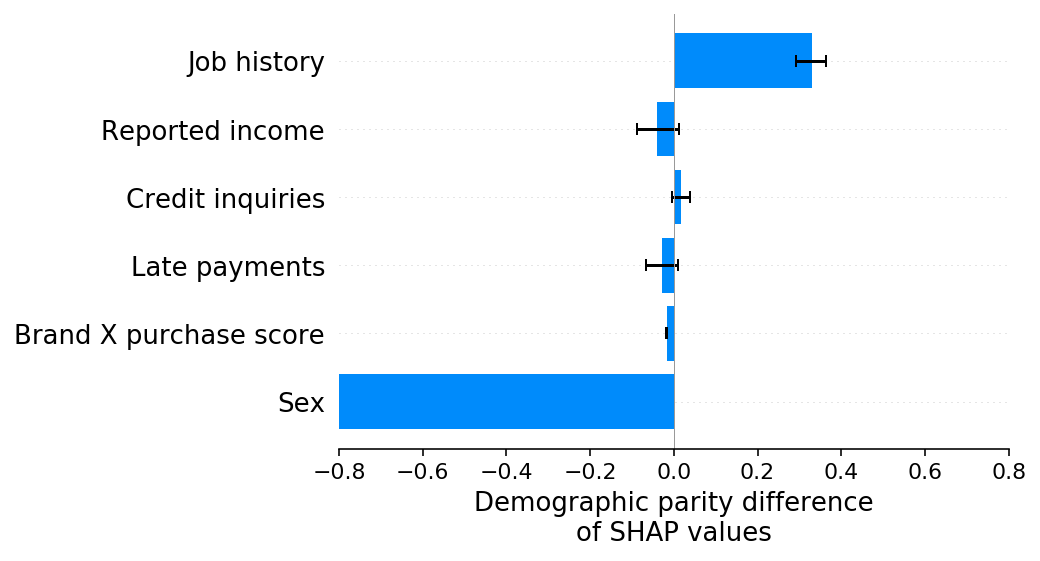

In [15]:
shap.group_difference_plot(shap_values_G, ~sex_G, X_G.columns, xmin=xmin, xmax=xmax, xlabel=gdiff_xlabel)

## Conclusion

Fairness is a deep and complex topic where clean mathmetical answers almost always come with caveats and depend on ethical value judgements. This means that it is particularly important to not just use fairness metrics as a black-box, but rather seek to understand how these metrics are computed and what aspects of your model and training data are impacting any disparities you observe. Decomposing quantitative fairness metrics using SHAP can reduce their opacity when the metrics are driven by measurement biases effecting only a few features. I hope you find the fairness explanations we demonstrated here help you better wrestle with the underlying value judgements inherent in fairness evaluation, and so help reduce the risk of unintended consequences that comes when we use fairness metrics in real world contexts.